In [46]:
# Cell 1: Import thư viện
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_excel('data_readed.xlsx')
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:
df = pd.read_excel('data_readed.xlsx')
df['datetime'] = pd.to_datetime(df['datetime'])


df = df[df['datetime'].dt.month.isin([4,10])].copy()
df['year'] = df['datetime'].dt.year


coord_cols = []
for c in ['lat','lon','row','col']:
    if c in df.columns:
        coord_cols.append(c)

group_cols = ['datetime'] + coord_cols
df = (
    df
    .groupby(group_cols)[ features + [target] ]
    .mean()
    .reset_index()
)

df2019 = df[df['datetime'].dt.year==2019].sort_values('datetime').reset_index(drop=True)
df2020 = df[df['datetime'].dt.year==2020].sort_values('datetime').reset_index(drop=True)


In [ ]:
scaler_f = StandardScaler()
df2019[features] = scaler_f.fit_transform(df2019[features])
df2020[features] = scaler_f.transform(df2020[features])


In [ ]:
def make_sequences(data, feats, tgt, window_size=3, horizon=6):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    for i in range(window_size, len(data)-horizon+1):
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


In [ ]:
# Tạo X_train, y_train từ toàn bộ 2019
window_size = 3
horizon     = 6

X_train, y_train = make_sequences(df2019, features, target, window_size, horizon)
print("Train shapes:", X_train.shape, y_train.shape)


Train shapes: (301927, 3, 9) (301927, 6)


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
lstm_scores, xgb_scores = [], []

for tr, vl in tscv.split(X_train):
    X_tr, X_vl = X_train[tr], X_train[vl]
    y_tr, y_vl = y_train[tr], y_train[vl]
    
    # --- LSTM với EarlyStopping ---
    model_l = Sequential([
        LSTM(50, input_shape=(window_size,len(features))),
        Dense(horizon)
    ])
    model_l.compile('adam','mse')
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model_l.fit(X_tr, y_tr, epochs=50, callbacks=[es], verbose=0)
    p_l = model_l.predict(X_vl)
    lstm_scores.append(np.sqrt(mean_squared_error(y_vl, p_l)))
    
    # --- XGBoost ---
    X_tr_f = X_tr.reshape(len(X_tr), -1)
    X_vl_f = X_vl.reshape(len(X_vl), -1)
    model_x = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1
    )
    model_x.fit(X_tr_f, y_tr, verbose=False)
    p_x = model_x.predict(X_vl_f)
    xgb_scores.append(np.sqrt(mean_squared_error(y_vl, p_x)))

l_rmse = np.mean(lstm_scores)
x_rmse = np.mean(xgb_scores)
w_l = 1/l_rmse
w_x = 1/x_rmse

print(f"LSTM CV RMSE:   {l_rmse:.4f}")
print(f"XGB   CV RMSE:   {x_rmse:.4f}")
print(f"Ensemble weights → LSTM: {w_l:.2f}, XGB: {w_x:.2f}")


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step
LSTM CV RMSE:   2.1548
XGB   CV RMSE:   3.2939
Ensemble weights → LSTM: 0.46, XGB: 0.30


In [ ]:
# — LSTM final —
lstm_final = Sequential([
    LSTM(50, input_shape=(window_size,len(features))),
    Dense(horizon)
])
lstm_final.compile('adam','mse')
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_final.fit(X_train, y_train, epochs=50, callbacks=[es], verbose=1)

# — XGBoost final —
Xf = X_train.reshape(len(X_train), -1)
xgb_final = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1
)
xgb_final.fit(Xf, y_train)


Epoch 1/50


c:\Users\giakh\.conda\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9436/9436 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 3.5106
Epoch 2/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.4589
Epoch 3/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.4325
Epoch 4/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.4103
Epoch 5/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3915
Epoch 6/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3755
Epoch 7/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3614
Epoch 8/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3485
Epoch 9/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3370
Epoch 10/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3266
Epoch 11/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3169
Epoch 12/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.3081
Epoch 13/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.2997
Epoch 14/50
9436/9436 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 3.2916
Epoch 15/50
9436/9436 ━━━━

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
test_day   = pd.to_datetime('2020-04-15 00:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size,0,-1)]


grid = df2020[ coord_cols ].drop_duplicates().reset_index(drop=True)
nP   = len(grid)

pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    # lấy subset cho điểm đó
    cond = True
    for c in coord_cols:
        cond &= (df2020[c] == pt[c])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    
    # window 3h input
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd = df_win[features].values.reshape(1, window_size, len(features))
    y_l = lstm_final.predict(Xd).flatten()
    y_x = xgb_final.predict(Xd.reshape(1,-1)).flatten()
    # ensemble trọng số
    y_e = (w_l*y_l + w_x*y_x) / (w_l + w_x)
    pred_map[:, idx] = y_e
    
    # actual 6h
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

C:\Users\giakh\AppData\Local\Temp\ipykernel_11184\1670366210.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


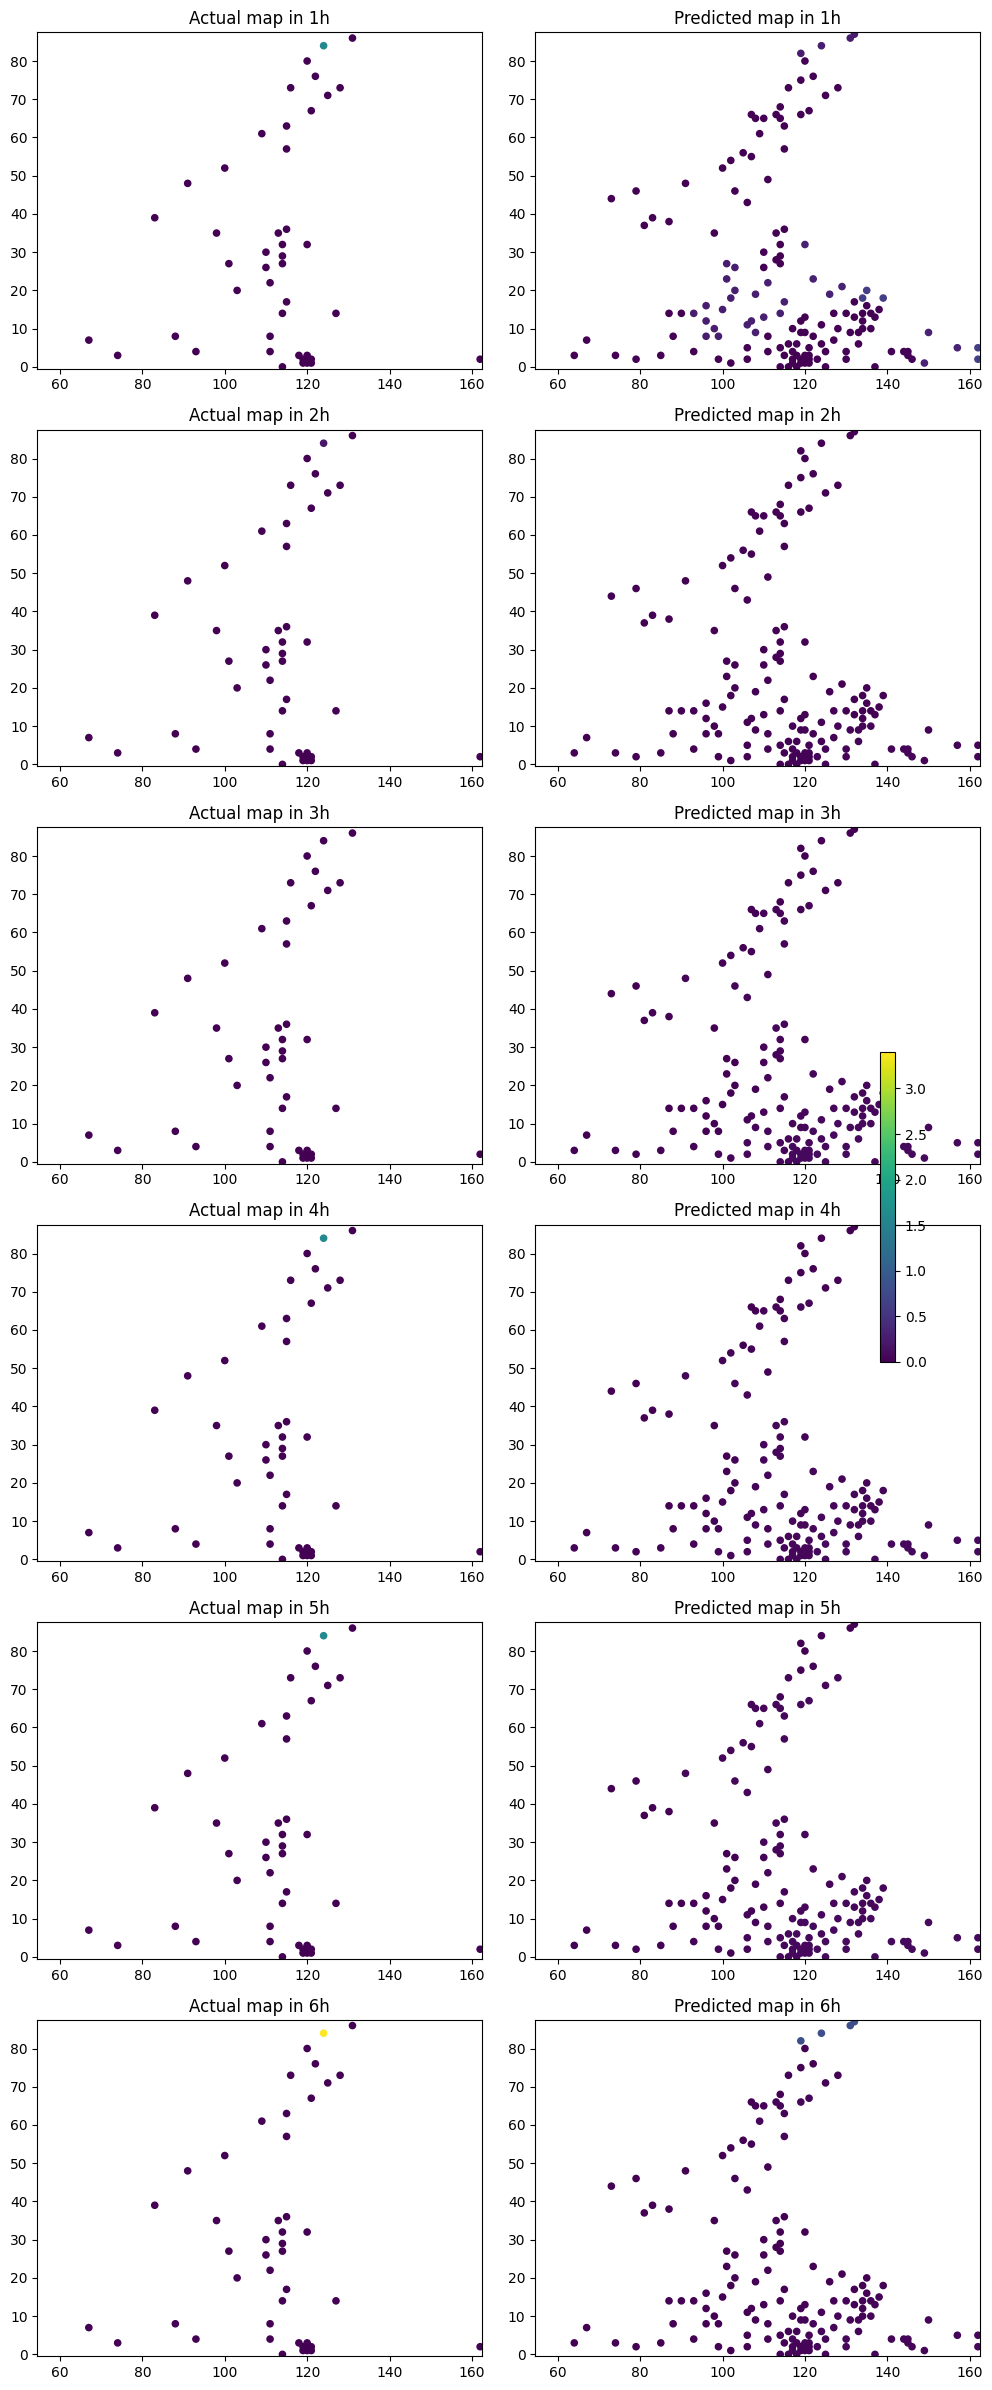

In [ ]:
import matplotlib.pyplot as plt
vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    ax1.scatter(grid[coord_cols[1]], grid[coord_cols[0]],
                c=act_map[h], cmap='viridis', vmin=vmin, vmax=vmax, s=20)
    ax1.set_title(f'Actual map in {h+1}h')
    ax2.scatter(grid[coord_cols[1]], grid[coord_cols[0]],
                c=pred_map[h], cmap='viridis', vmin=vmin, vmax=vmax, s=20)
    ax2.set_title(f'Predicted map in {h+1}h')
    xmn, xmx = grid[coord_cols[1]].min(), grid[coord_cols[1]].max()
    ymn, ymx = grid[coord_cols[0]].min(), grid[coord_cols[0]].max()
    ax1.set_xlim(xmn-0.5, xmx+0.5);  ax1.set_ylim(ymn-0.5, ymx+0.5)
    ax2.set_xlim(xmn-0.5, xmx+0.5);  ax2.set_ylim(ymn-0.5, ymx+0.5)

fig.colorbar(axes[0,0].collections[0], ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()


Test Day 2020-04-15 → RMSE=0.243, MAE=0.071, R²=0.161


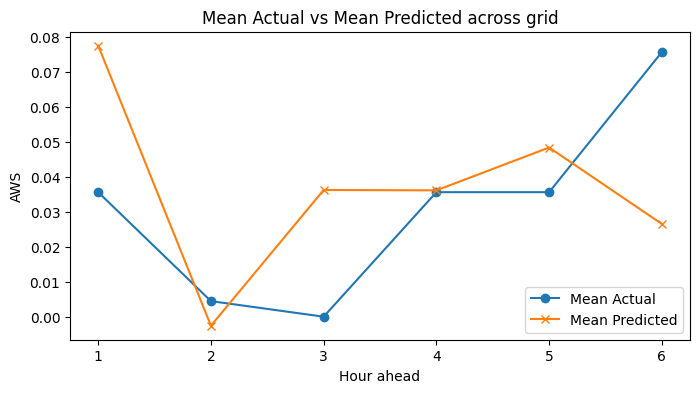

In [56]:
# Cell 11: Metrics & line chart Mean Actual vs Mean Predicted
mask = ~np.isnan(act_map) & ~np.isnan(pred_map)
all_act = act_map[mask]
all_prd = pred_map[mask]

rmse = np.sqrt(mean_squared_error(all_act, all_prd))
mae  = mean_absolute_error(all_act, all_prd)
r2   = r2_score(all_act, all_prd)
print(f"Test Day {test_day.date()} → RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

mean_act = np.nanmean(act_map, axis=1)
mean_prd = np.nanmean(pred_map, axis=1)
hours = np.arange(1, horizon+1)

plt.figure(figsize=(8,4))
plt.plot(hours, mean_act, marker='o', label='Mean Actual')
plt.plot(hours, mean_prd, marker='x', label='Mean Predicted')
plt.xlabel('Hour ahead')
plt.ylabel('AWS')
plt.title('Mean Actual vs Mean Predicted across grid')
plt.legend()
plt.show()
